<a href="https://colab.research.google.com/github/KormazovaVer/CNN/blob/main/task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchvision import datasets, models, transforms
import torch.optim as optim
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import os
import sys
from google.colab import drive

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/hymenoptera_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cuda')

In [ ]:
dataloaders['train'], dataloaders['val']

(<torch.utils.data.dataloader.DataLoader at 0x7f9240731ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9240731d00>)

In [ ]:
image_datasets['train'][0][0].shape

torch.Size([3, 224, 224])

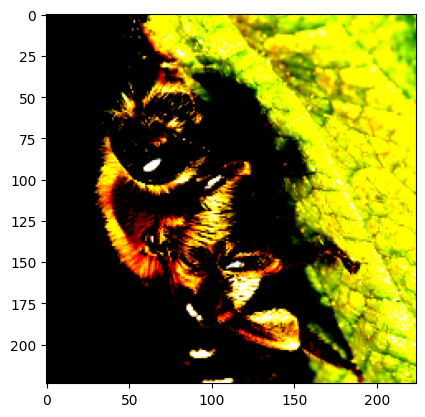

bees


In [ ]:
image,label = image_datasets['train'][225]
plt.imshow(image.permute(2,1,0))
plt.show()
print(image_datasets['train'].classes[label])

In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
loss_RN18 =[]
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            loss_RN18.append(train_l_sum / n)
            #print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
             #   (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

1. ResNet18 c 0

In [ ]:
model_resnet_0 = models.resnet18()

In [ ]:
model_resnet_0 = model_resnet_0.to(dev)

In [ ]:
print(model_resnet_0)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_resnet_0.fc = nn.Linear(in_features=512, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.0001, 50
trainer = torch.optim.Adam(model_resnet_0.parameters(), lr=lr)
train(model_resnet_0, dataloaders['train'], dataloaders['val'],
      trainer, num_epochs, dev)

epoch 1, loss 0.6532, train acc 0.566, test acc 0.484, time 5.0 sec
epoch 2, loss 0.7239, train acc 0.586, test acc 0.542, time 6.4 sec
epoch 3, loss 0.6681, train acc 0.627, test acc 0.542, time 4.9 sec
epoch 4, loss 0.5688, train acc 0.701, test acc 0.673, time 5.7 sec
epoch 5, loss 0.5766, train acc 0.709, test acc 0.582, time 5.7 sec
epoch 6, loss 0.5838, train acc 0.676, test acc 0.699, time 4.8 sec
epoch 7, loss 0.5877, train acc 0.693, test acc 0.693, time 6.3 sec
epoch 8, loss 0.5165, train acc 0.734, test acc 0.680, time 4.9 sec
epoch 9, loss 0.6629, train acc 0.672, test acc 0.542, time 5.4 sec
epoch 10, loss 0.6210, train acc 0.643, test acc 0.660, time 6.1 sec
epoch 11, loss 0.5563, train acc 0.713, test acc 0.712, time 4.9 sec
epoch 12, loss 0.5292, train acc 0.725, test acc 0.745, time 6.4 sec
epoch 13, loss 0.5022, train acc 0.730, test acc 0.745, time 4.9 sec
epoch 14, loss 0.4492, train acc 0.783, test acc 0.667, time 5.0 sec
epoch 15, loss 0.4793, train acc 0.742, tes

In [ ]:
torch.cuda.empty_cache()

2. VGG16 c 0

In [ ]:
loss_VGG16 =[]
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            loss_VGG16.append(train_l_sum / n)
            #print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
             #   (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
model_vgg_0 = models.vgg16()

In [ ]:
model_vgg_0 = model_vgg_0.to(dev)

In [ ]:
print(model_vgg_0)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_vgg_0.classifier._modules['6'] = nn.Linear(4096, 2).to(dev)

In [ ]:
lr, num_epochs = 0.0001, 50
trainer = torch.optim.Adam(model_vgg_0.parameters(), lr=lr)
train(model_vgg_0, dataloaders['train'], dataloaders['val'],
      trainer, num_epochs, dev)

epoch 1, loss 0.7116, train acc 0.508, test acc 0.458, time 8.7 sec
epoch 2, loss 0.6928, train acc 0.508, test acc 0.582, time 9.4 sec
epoch 3, loss 0.7143, train acc 0.557, test acc 0.542, time 8.9 sec
epoch 4, loss 0.6917, train acc 0.537, test acc 0.542, time 8.3 sec
epoch 5, loss 0.6834, train acc 0.512, test acc 0.654, time 9.5 sec
epoch 6, loss 0.6913, train acc 0.525, test acc 0.458, time 9.4 sec
epoch 7, loss 0.6862, train acc 0.525, test acc 0.556, time 8.2 sec
epoch 8, loss 0.7006, train acc 0.574, test acc 0.627, time 9.1 sec
epoch 9, loss 0.6568, train acc 0.545, test acc 0.582, time 10.2 sec
epoch 10, loss 0.6590, train acc 0.672, test acc 0.621, time 8.3 sec
epoch 11, loss 0.6564, train acc 0.598, test acc 0.673, time 8.8 sec
epoch 12, loss 0.6404, train acc 0.664, test acc 0.562, time 9.2 sec
epoch 13, loss 0.6553, train acc 0.602, test acc 0.542, time 9.0 sec
epoch 14, loss 0.5916, train acc 0.668, test acc 0.686, time 8.6 sec
epoch 15, loss 0.5633, train acc 0.730, te

In [ ]:
torch.cuda.empty_cache()

3. Inception v3 c O

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(299),
        transforms.RandomCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = '/content/drive/My Drive/hymenoptera_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [ ]:
dataloaders['train'], dataloaders['val']

(<torch.utils.data.dataloader.DataLoader at 0x7f92402c27c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f92661319a0>)

In [ ]:
image_datasets['train'][0][0].shape

torch.Size([3, 299, 299])

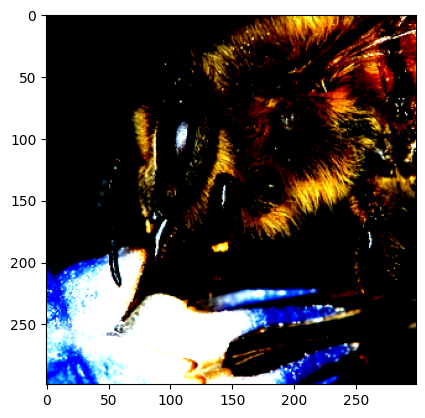

bees


In [ ]:
image,label = image_datasets['train'][220]
plt.imshow(image.permute(2,1,0))
plt.show()
print(image_datasets['train'].classes[label])

In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
loss_Incv3 = []
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            loss_Incv3.append(train_l_sum / n)
            #print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
             #   (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))


In [ ]:
model_inception_0 = models.inception_v3(aux_logits=False)

/usr/local/lib/python3.9/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
model_inception_0 = model_inception_0.to(dev)

In [ ]:
print(model_inception_0)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model_inception_0.fc = nn.Linear(in_features=2048, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.0001, 50
trainer = torch.optim.Adam(model_inception_0.parameters(), lr=lr)
train(model_inception_0, dataloaders['train'], dataloaders['val'],
      trainer, num_epochs, dev)

epoch 1, loss 0.7083, train acc 0.520, test acc 0.464, time 7.2 sec
epoch 2, loss 1.2529, train acc 0.504, test acc 0.542, time 5.9 sec
epoch 3, loss 0.6896, train acc 0.557, test acc 0.556, time 7.0 sec
epoch 4, loss 0.6460, train acc 0.631, test acc 0.660, time 5.9 sec
epoch 5, loss 0.6305, train acc 0.623, test acc 0.464, time 7.4 sec
epoch 6, loss 0.6758, train acc 0.623, test acc 0.647, time 6.1 sec
epoch 7, loss 0.6044, train acc 0.652, test acc 0.641, time 7.4 sec
epoch 8, loss 0.5933, train acc 0.672, test acc 0.549, time 6.0 sec
epoch 9, loss 0.5585, train acc 0.709, test acc 0.673, time 7.6 sec
epoch 10, loss 0.5241, train acc 0.713, test acc 0.595, time 6.0 sec
epoch 11, loss 0.5246, train acc 0.734, test acc 0.569, time 7.9 sec
epoch 12, loss 0.5392, train acc 0.676, test acc 0.516, time 6.1 sec
epoch 13, loss 0.5962, train acc 0.656, test acc 0.627, time 7.8 sec
epoch 14, loss 0.4690, train acc 0.754, test acc 0.680, time 5.9 sec
epoch 15, loss 0.4223, train acc 0.799, tes

In [ ]:
torch.cuda.empty_cache()

4.DenseNet161 с 0

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = '/content/drive/My Drive/hymenoptera_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [ ]:
loss_DN16 = []
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            loss_DN16.append(train_l_sum / n)
            #print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
             #   (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [ ]:
dataloaders['train'], dataloaders['val']

(<torch.utils.data.dataloader.DataLoader at 0x7f924746ac70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f924746abb0>)

In [ ]:
image_datasets['train'][0][0].shape

torch.Size([3, 224, 224])

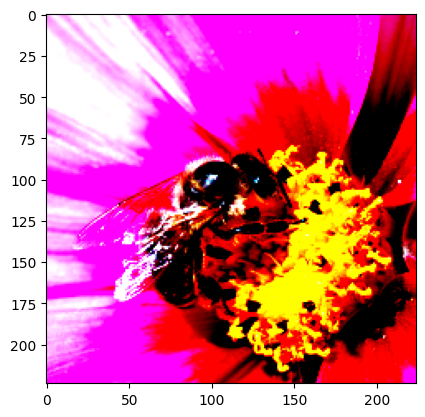

bees


In [ ]:
image,label = image_datasets['train'][200]
plt.imshow(image.permute(2,1,0))
plt.show()
print(image_datasets['train'].classes[label])

In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
model_densenet_0 = models.densenet161()

In [ ]:
model_densenet_0 = model_densenet_0.to(dev)

In [ ]:
print(model_densenet_0)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
model_densenet_0.classifier = nn.Linear(in_features=2208, out_features=2).to(dev)

In [ ]:
lr, num_epochs = 0.0001, 50
trainer = torch.optim.Adam(model_densenet_0.parameters(), lr=lr)
train(model_densenet_0, dataloaders['train'], dataloaders['val'],
      trainer, num_epochs, dev)

epoch 1, loss 0.6796, train acc 0.627, test acc 0.569, time 12.3 sec
epoch 2, loss 0.7241, train acc 0.607, test acc 0.542, time 10.7 sec
epoch 3, loss 0.5931, train acc 0.684, test acc 0.647, time 12.9 sec
epoch 4, loss 0.5634, train acc 0.697, test acc 0.621, time 11.6 sec
epoch 5, loss 0.5449, train acc 0.660, test acc 0.680, time 10.9 sec
epoch 6, loss 0.4840, train acc 0.754, test acc 0.634, time 12.0 sec
epoch 7, loss 0.5136, train acc 0.746, test acc 0.686, time 10.8 sec
epoch 8, loss 0.4817, train acc 0.738, test acc 0.588, time 11.2 sec
epoch 9, loss 0.5085, train acc 0.701, test acc 0.667, time 11.7 sec
epoch 10, loss 0.4695, train acc 0.770, test acc 0.608, time 10.7 sec
epoch 11, loss 0.4057, train acc 0.803, test acc 0.654, time 11.9 sec
epoch 12, loss 0.3768, train acc 0.832, test acc 0.686, time 11.1 sec
epoch 13, loss 0.3189, train acc 0.857, test acc 0.654, time 11.1 sec
epoch 14, loss 0.4790, train acc 0.787, test acc 0.634, time 12.1 sec
epoch 15, loss 0.3569, train 

Таблица сравнения


In [ ]:

import pandas as pd
df = pd.DataFrame({'loss_RN18' : loss_RN18,
                   'loss_VGG16' : loss_VGG16,
                   'loss_Incv3' : loss_Incv3,
                   'loss_DN16' : loss_DN16})
df

In [ ]:
df.describe()

,loss_RN18,loss_VGG16,loss_Incv3,loss_DN16
count,800.000000,800.000000,800.000000,800.000000
mean,0.349208,0.507877,0.436485,0.298933
std,0.202802,0.132035,0.208525,0.165467
min,0.001739,0.173802,0.056260,0.024032
25%,0.162645,0.404667,0.302724,0.169149
50%,0.337699,0.495529,0.416499,0.277268
75%,0.500746,0.634653,0.545349,0.408970
max,1.162125,0.807094,1.551974,0.785037
